# Analysis of the effect of starting locations on angular error in HumanA
author: Nora Maleki (noora.maleki@gmail.com)
April 2022

## Import libraries

In [281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import statsmodels.formula.api as smf
import researchpy as rp

from matplotlib.lines import Line2D

%matplotlib inline

In [282]:
colorblind_palette = ['#2d004b', '#5ab4ac', '#b2182b', '#8c510a','#4575b4','#8073ac']
sns.set_theme(font_scale=1, palette=colorblind_palette, style='darkgrid')

## Load data

In [283]:
FILE_PATH = r'../../data/01_main'
PLOT_PATH = f'{FILE_PATH}/plots/analysis/'
IMG_PATH = r'../../supplementary_material/images/'

os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)
os.makedirs(os.path.dirname(IMG_PATH), exist_ok=True)

In [284]:
df_cleaned = pd.read_csv(f'{FILE_PATH}/07_preprocessed.csv')
df_cleaned.head()

,subject_id,body_pos_x,body_pos_z,pointer_pos_x,pointer_pos_z,pointer_dir_x,pointer_dir_z,building_center_z,building_center_x,human_agent,...,dir_to_x_360,signed_180_angles,final_360_angles,rounded_180_angles,rounded_360_angles,absolute_180_angles,target_building_name,starting_loc_name,starting_loc_meaningfulness,starting_loc_meaningful
0,365,-114.329147,-139.997375,-114.236984,-139.696228,-0.055459,0.989548,53.288437,-72.578285,46,...,93.207763,-15.396716,344.603284,-15.0,345.0,15.396716,R (underwater),S (tool shop),True,True
1,365,-65.669235,-159.945099,-65.474716,-159.710205,0.072550,0.992235,53.288437,-72.578285,46,...,85.818077,6.037733,6.037733,6.0,6.0,6.037733,R (underwater),R (motorbike),False,False
2,365,38.849380,53.547638,38.471634,53.516281,-0.993265,-0.112792,53.288437,-72.578285,46,...,186.478570,-6.345290,353.654710,-6.0,354.0,6.345290,R (underwater),R (purpul bat),False,False
3,365,38.880081,53.564148,38.700195,53.581047,-0.995648,-0.065598,53.288437,-72.578285,46,...,183.769483,-3.627752,356.372248,-4.0,356.0,3.627752,R (underwater),R (purpul bat),False,False
4,365,110.754181,196.522675,110.428146,196.550751,-0.941145,-0.321944,53.288437,-72.578285,46,...,198.884612,19.115237,19.115237,19.0,19.0,19.115237,R (underwater),R (bottle spray),False,False


## Exploring the data

In [285]:
lmm_df = (df_cleaned[['absolute_180_angles', 'RT', 'distance_to_target']]
           .assign(subject_id=df_cleaned.subject_id.astype('category'),
                   starting_loc_id=df_cleaned.starting_loc_id.astype('category'),
                   starting_loc_name=df_cleaned.starting_loc_name.astype('category'),
                   human_agent=df_cleaned.human_agent.astype('category'),
                   trial_id_per_location=df_cleaned.trial_id_per_location.astype('category'),
                   trial_id=df_cleaned.trial_id.astype('category'),
                   starting_loc_meaningful=df_cleaned.starting_loc_meaningful.astype('category')
                   ))

lmm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7708 entries, 0 to 7707
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   absolute_180_angles      7708 non-null   float64 
 1   RT                       7708 non-null   float64 
 2   distance_to_target       7708 non-null   float64 
 3   subject_id               7708 non-null   category
 4   starting_loc_id          7708 non-null   category
 5   starting_loc_name        7708 non-null   category
 6   human_agent              7708 non-null   category
 7   trial_id_per_location    7708 non-null   category
 8   trial_id                 7708 non-null   category
 9   starting_loc_meaningful  7708 non-null   category
dtypes: category(7), float64(3)
memory usage: 258.0 KB


In [286]:
N = lmm_df.subject_id.nunique()
N

23

In [287]:
rp.codebook(lmm_df)

Variable: absolute_180_angles    Data Type: float64 

 Number of Obs.: 7708 
 Number of missing obs.: 0 
 Percent missing: 0.0 
 Number of unique values: 7708 

 Range: [0.0098611111833122, 179.98338618386347] 
 Mean: 48.08 
 Standard Deviation: 44.3 
 Mode: 0.0098611111833122 
 10th Percentile: 4.061728074435263 
 25th Percentile: 12.864763109725644 
 50th Percentile: 33.697730978897454 
 75th Percentile: 71.5482171723512 
 90th Percentile: 117.00126423211762 





Variable: RT    Data Type: float64 

 Number of Obs.: 7708 
 Number of missing obs.: 0 
 Percent missing: 0.0 
 Number of unique values: 7684 

 Range: [0.955792665481567, 29.289794206619263] 
 Mean: 7.77 
 Standard Deviation: 5.56 
 Mode: 1.3769052028656 
 10th Percentile: 2.431258296966553 
 25th Percentile: 3.621542990207672 
 50th Percentile: 6.063600659370422 
 75th Percentile: 10.153734385967253 
 90th Percentile: 15.809007906913761 





Variable: distance_to_target    Data Type: float64 

 Number of Obs.: 7708 
 Num

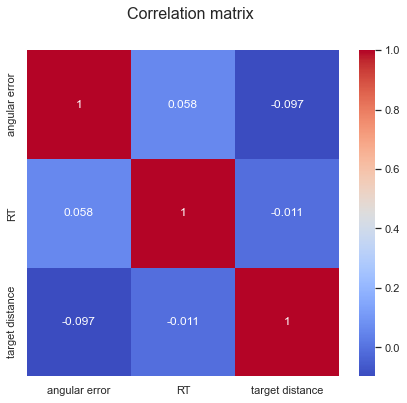

In [288]:
fig, _ = plt.subplots(figsize = (7, 6))

sns.heatmap(
    data=(lmm_df
          .rename(columns={'absolute_180_angles' : 'angular error',
                           'distance_to_target' : 'target distance'})
          .corr()),
    annot = True,
    fmt='.2g',
    cmap= 'coolwarm'
)

plt.suptitle(t='Correlation matrix', size=16, x=.45)

plt.show()

fig.savefig(f'{PLOT_PATH}/correlation_matrix_{N}.png', bbox_inches='tight', dpi=90)

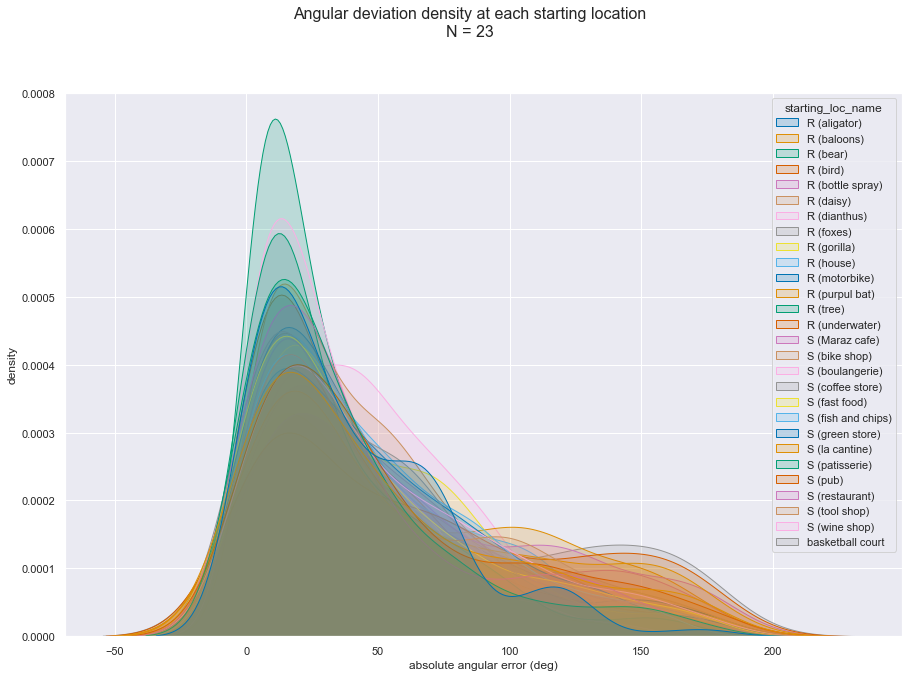

In [289]:
fig, _ = plt.subplots(figsize=(15,10))

sns.kdeplot(
    data=lmm_df,
    x='absolute_180_angles',
    hue='starting_loc_name',
    fill=True,
    palette='colorblind',
    alpha=.2,
).set(xlabel='absolute angular error (deg)', ylabel='density')


plt.suptitle(f'Angular deviation density at each starting location\nN = {N}', size=16, y=1)

fig.savefig(f'{PLOT_PATH}/density_angular_error_per_starting_location_{N}.png', bbox_inches='tight', dpi=90)

plt.show()

In [290]:
mean_median_angle_RT = df_cleaned.groupby(['starting_loc_name', 'starting_loc_id'])[['absolute_180_angles', 'RT']].agg([np.mean, np.median]).reset_index()
mean_median_angle_RT

starting_loc_name starting_loc_id absolute_180_angles             \
                                                      mean     median   
0         R (aligator)              25           39.210534  28.955402   
1          R (baloons)              18           51.974447  35.074110   
2             R (bear)               7           38.726416  25.515426   
3             R (bird)              55           52.320296  37.695538   
4     R (bottle spray)              19           43.025639  28.005307   
5            R (daisy)              43           51.947655  34.293670   
6         R (dianthus)              40           51.191782  37.988246   
7            R (foxes)               1           46.730955  35.664767   
8          R (gorilla)               4           45.796754  29.536517   
9            R (house)              37           47.116459  37.384374   
10       R (motorbike)              36           48.984223  37.948755   
11      R (purpul bat)              30           59.634057  37.568774   
12            R (tree)              54           35.766733  21.200922   
13      R (underwater)              35           65.283762  52.494056   
14      S (Maraz cafe)               5           62.774833  51.251063   
15       S (bike shop)              38           39.224917  31.612215   
16     S (boulangerie)               2           33.525668  23.517914   
17    S (coffee store)              21           45.184079  29.532780   
18       S (fast food)              20           48.065795  35.356497   
19  S (fish and chips)              34           47.018872  35.346270   
20     S (green store)              45           45.285526  30.349194   
21      S (la cantine)              52           60.925282  47.160429   
22      S (patisserie)               9           27.502741  19.176842   
23             S (pub)              14           41.370585  27.834337   
24      S (restaurant)              29           56.852515  41.598931   
25       S (tool shop)              44           45.727937  32.478852   
26       S (wine shop)              51           48.430897  43.256934   
27    basketball court              58           66.847982  49.849104   

          RT            
        mean    median  
0   7.302352  5.570076  
1   8.584581  6.919941  
2   7.737437  6.015261  
3   7.849885  5.603920  
4   6.516070  5.278179  
5   8.664658  6.894657  
6   8.515813  6.350540  
7   7.400864  5.622906  
8   6.688874  5.334976  
9   8.680552  6.694255  
10  7.528648  6.293741  
11  8.479499  6.401871  
12  8.182545  6.274397  
13  9.081363  7.746539  
14  8.556873  7.490835  
15  7.607551  5.647205  
16  7.060426  5.233317  
17  7.421424  5.893713  
18  6.658104  5.803198  
19  8.181344  6.204588  
20  8.205571  6.329449  
21  8.086564  6.553893  
22  7.448431  5.487761  
23  8.277638  6.422948  
24  7.220371  6.004342  
25  7.424411  5.492207  
26  6.694309  4.627191  
27  7.445384  5.829484

In [291]:
mean_median_overall = mean_median_angle_RT.iloc[:,1:].agg([np.mean, np.median])
mean_median_overall

starting_loc_id absolute_180_angles                   RT          
                                      mean     median      mean    median
mean              29.5           48.087405  34.915972  7.767912  6.072192
median            32.0           47.067666  35.210190  7.672494  6.009801

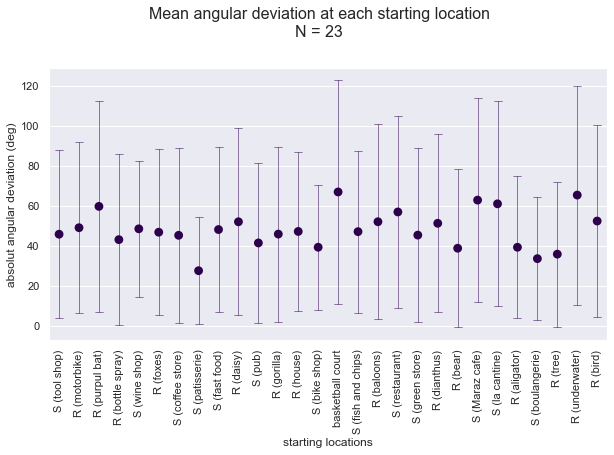

In [292]:
fig, _ = plt.subplots(figsize=(10,5))

sns.pointplot(
    data=df_cleaned,
    x='starting_loc_name',
    y='absolute_180_angles',
    ci='sd',
    join=False,
    errwidth=.5,
    capsize=.4,
).set(xlabel='starting locations', ylabel='absolut angular deviation (deg)')

plt.suptitle(f'Mean angular deviation at each starting location\nN = {N}', size=16, y=1.05)
plt.xticks(rotation=90)
plt.show()

fig.savefig(f'{PLOT_PATH}/mean_angular_deviation_pointplot_{N}.png', bbox_inches='tight', dpi=90)

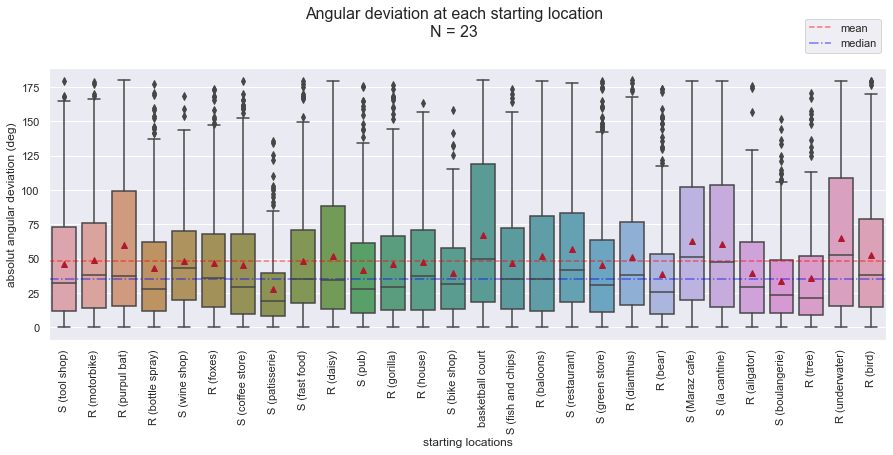

In [293]:
fig, _ = plt.subplots(figsize=(15,5))

sns.boxplot(
    data=df_cleaned,
    x='starting_loc_name',
    y='absolute_180_angles',
    showmeans= True,
    saturation=.5,
).set(xlabel='starting locations', ylabel='absolut angular deviation (deg)')

plt.axhline(y=mean_median_overall.loc['mean', ('absolute_180_angles', 'mean')], alpha=.5, ls='--', c='r', label='mean')
plt.axhline(y=mean_median_overall.loc['median', ('absolute_180_angles', 'median')], alpha=.5, ls='-.', c='b', label='median')

plt.suptitle(f'Angular deviation at each starting location\nN = {N}', size=16, y=1.05)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 1.2), loc='upper right')
plt.show()

fig.savefig(f'{PLOT_PATH}/angular_deviation_boxplot_{N}.png', bbox_inches='tight', dpi=90)

## Creating DataFrames

In [300]:
lmm_summary_angle = (
    (
    pd.merge(
        rp.summary_cont(lmm_df.groupby(['starting_loc_id'])['absolute_180_angles']),
        lmm_df.groupby(['starting_loc_id'])['absolute_180_angles'].agg(np.median),
        left_index=True,
        right_index=True,
        how='left')
).rename(columns={'absolute_180_angles': 'Median'})
        .reset_index()
        .assign(
            starting_loc_name=lmm_df.starting_loc_id.map(pd.Series(lmm_df.starting_loc_name.values, index=lmm_df.starting_loc_id).to_dict()),
            starting_loc_meaningful=lmm_df.starting_loc_id.map(pd.Series(lmm_df.starting_loc_meaningful.values, index=lmm_df.starting_loc_id).to_dict())
        )
        .sort_values('Median')
)

col_to_move = lmm_summary_angle.pop('starting_loc_name')
lmm_summary_angle.insert(1, 'starting_loc_name', col_to_move)
col_to_move = lmm_summary_angle.pop('starting_loc_meaningful')
lmm_summary_angle.insert(2, 'starting_loc_meaningful', col_to_move)

del col_to_move
lmm_summary_angle

,starting_loc_id,starting_loc_name,starting_loc_meaningful,N,Mean,SD,SE,95% Conf.,Interval,Median
5,9,S (wine shop),True,276,27.5027,26.7153,1.6081,24.3370,30.6684,19.176842
25,54,S (coffee store),True,273,35.7667,36.3543,2.2003,31.4350,40.0984,21.200922
1,2,R (motorbike),False,276,33.5257,30.9483,1.8629,29.8584,37.1930,23.517914
4,7,R (bottle spray),False,274,38.7264,39.5038,2.3865,34.0281,43.4247,25.515426
6,14,R (foxes),False,276,41.3706,40.0602,2.4113,36.6236,46.1176,27.834337
8,19,S (patisserie),True,276,43.0256,42.7547,2.5735,37.9593,48.0920,28.005307
11,25,S (fast food),True,276,39.2105,35.4404,2.1333,35.0109,43.4101,28.955402
10,21,S (tool shop),True,274,45.1841,43.9356,2.6542,39.9587,50.4095,29.532780
2,4,R (purpul bat),False,276,45.7968,43.7805,2.6353,40.6089,50.9846,29.536517
22,45,R (house),False,275,45.2855,43.6882,2.6345,40.0991,50.4720,30.349194


In [301]:
lmm_summary_RT = (
    (
        pd.merge(
            rp.summary_cont(lmm_df.groupby(['starting_loc_id'])['RT']),
            lmm_df.groupby(['starting_loc_id'])['RT'].agg(np.median),
            left_index=True,
            right_index=True,
            how='left')
    ).rename(columns={'RT': 'Median'})
        .reset_index()
        .assign(
            starting_loc_name=lmm_df.starting_loc_id.map(pd.Series(lmm_df.starting_loc_name.values, index=lmm_df.starting_loc_id).to_dict()),
            starting_loc_meaningful=lmm_df.starting_loc_id.map(pd.Series(lmm_df.starting_loc_meaningful.values, index=lmm_df.starting_loc_id).to_dict())
        )
        .sort_values('Median')
)

col_to_move = lmm_summary_RT.pop('starting_loc_name')
lmm_summary_RT.insert(1, 'starting_loc_name', col_to_move)
col_to_move = lmm_summary_RT.pop('starting_loc_meaningful')
lmm_summary_RT.insert(2, 'starting_loc_meaningful', col_to_move)

del col_to_move
lmm_summary_RT

,starting_loc_id,starting_loc_name,starting_loc_meaningful,N,Mean,SD,SE,95% Conf.,Interval,Median
23,51,S (bike shop),True,276,6.6943,5.4483,0.3280,6.0487,7.3399,4.627191
1,2,R (motorbike),False,276,7.0604,5.1914,0.3125,6.4453,7.6756,5.233317
8,19,S (patisserie),True,276,6.5161,4.6564,0.2803,5.9643,7.0678,5.278179
2,4,R (purpul bat),False,276,6.6889,4.5912,0.2764,6.1448,7.2329,5.334976
5,9,S (wine shop),True,276,7.4484,5.6395,0.3395,6.7802,8.1167,5.487761
21,44,S (tool shop),True,276,7.4244,5.5829,0.3361,6.7628,8.0860,5.492207
11,25,S (fast food),True,276,7.3024,5.2810,0.3179,6.6766,7.9281,5.570076
26,55,R (daisy),False,275,7.8499,6.1923,0.3734,7.1148,8.5850,5.603920
0,1,S (tool shop),True,276,7.4009,5.2885,0.3183,6.7742,8.0275,5.622906
18,38,S (pub),True,276,7.6076,5.7867,0.3483,6.9218,8.2933,5.647205


## Extreme starting locations

### Angular error

#### Starting location with the `best` angular performance

In [302]:
s_median = lmm_summary_angle.Median.min()
best_df = lmm_summary_angle.query('Median==@s_median')
ID = best_df.starting_loc_id.values[0]
sl_name = lmm_df.query('starting_loc_id==@ID').starting_loc_name.unique()[0]

display(
    'Best starting location',
    f'name: {sl_name}',
    f'ID: {ID}',
    f'median: {np.round(best_df.Median.values[0], 3)}',
    f'difference to overall median: {np.round(np.abs(np.median(lmm_summary_angle.Median) - best_df.Median.values[0]), 3)}',
    f'overall median: {np.round(np.median(lmm_summary_angle.Median), 3)}',
    f'summary statistics',
    best_df,
)

'Best starting location'

'name: S (patisserie)'

'ID: 9'

'median: 19.177'

'difference to overall median: 16.033'

'overall median: 35.21'

'summary statistics'

,starting_loc_id,starting_loc_name,starting_loc_meaningful,N,Mean,SD,SE,95% Conf.,Interval,Median
5,9,S (wine shop),True,276,27.5027,26.7153,1.6081,24.337,30.6684,19.176842


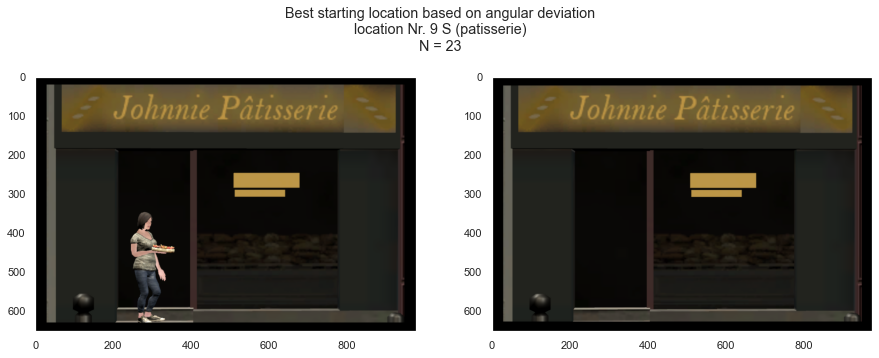

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

img_9_A = mpimg.imread(f'{IMG_PATH}/starting_locations/09_S(patisserie)_A.PNG')
img_9_noA = mpimg.imread(f'{IMG_PATH}/starting_locations/09_S(patisserie)_noA.PNG')

axes[0].imshow(img_9_A)
axes[1].imshow(img_9_noA)

[ax.grid(None) for ax in axes]

plt.suptitle(f'Best starting location based on angular deviation\nlocation Nr. 9 S (patisserie)\nN = {N}', y=1.05)

fig.savefig(f'{PLOT_PATH}/best_loc_angular_error_{N}.png', bbox_inches='tight', dpi=90)

plt.show()

#### Starting location with the `worst` angular performance

In [19]:
l_median = lmm_summary_angle.Median.max()
worst_df = lmm_summary_angle.query('Median==@l_median')
ID = worst_df.starting_loc_id.values[0]
sl_name = lmm_df.query('starting_loc_id==@ID').starting_loc_name.unique()[0]

display(
    'Worst starting location',
    f'name: {sl_name}',
    f'ID: {ID}',
    f'median: {np.round(worst_df.Median.values[0], 3)}',
    f'difference to overall median: {np.round(np.abs(np.median(lmm_summary_angle.Median) - worst_df.Median.values[0]), 3)}',
    f'overall median: {np.round(np.median(lmm_summary_angle.Median), 3)}',
    f'summary statistics',
    worst_df,
)

'Worst starting location'

'name: R (underwater)'

'ID: 35'

'median: 52.494'

'difference to overall median: 17.284'

'overall median: 35.21'

'summary statistics'

,starting_loc_id,starting_loc_name,N,Mean,SD,SE,95% Conf.,Interval,Median
15,35,S (tool shop),272,65.2838,54.8018,3.3228,58.7419,71.8256,52.494056


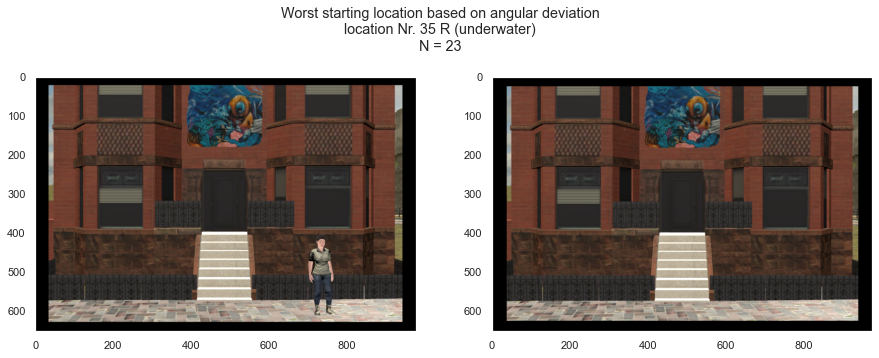

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

img_35_A = mpimg.imread(f'{IMG_PATH}/starting_locations/35_R(underwater)_A.PNG')
img_35_noA = mpimg.imread(f'{IMG_PATH}/starting_locations/35_R(underwater)_noA.PNG')

axes[0].imshow(img_35_A)
axes[1].imshow(img_35_noA)

[ax.grid(None) for ax in axes]

plt.suptitle(f'Worst starting location based on angular deviation\nlocation Nr. 35 R (underwater)\nN = {N}', y=1.05)

fig.savefig(f'{PLOT_PATH}/worst_loc_angular_error_{N}.png', bbox_inches='tight', dpi=90)

plt.show()

#### Difference between lowest median angular error and highest

In [21]:
np.round((worst_df.Median.values[0] - best_df.Median.values[0]), 3)

33.317

#### Plot

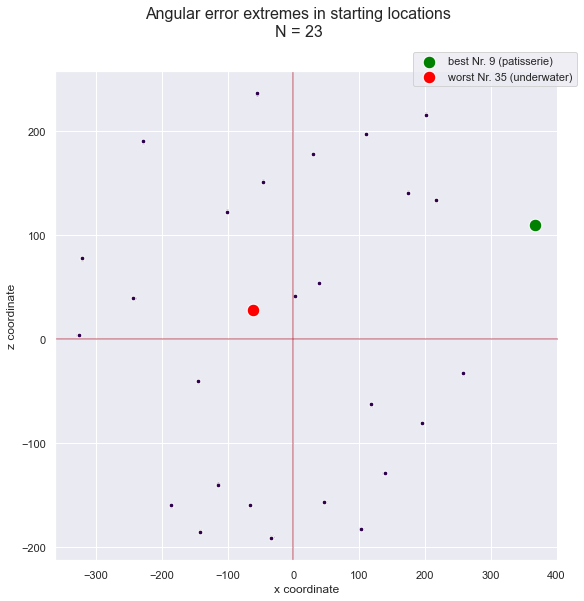

In [22]:
fig, _ = plt.subplots(figsize=(9,9))

best_loc_coord = df_cleaned.query('starting_loc_id == 9')[['starting_loc_x', 'starting_loc_z']].drop_duplicates(keep='first')
worst_loc_coord = df_cleaned.query('starting_loc_id == 35')[['starting_loc_x', 'starting_loc_z']].drop_duplicates(keep='first')

sns.scatterplot(
    data=df_cleaned,
    x='body_pos_x',
    y='body_pos_z',
    s=80,
    marker='.'
).set(xlabel='x coordinate', ylabel='z coordinate')

sns.scatterplot(
    data=best_loc_coord,
    x='starting_loc_x',
    y='starting_loc_z',
    s=160,
    c=['green'],
    marker='o',
    label='best Nr. 9 (patisserie)',
)

sns.scatterplot(
    data=worst_loc_coord,
    x='starting_loc_x',
    y='starting_loc_z',
    s=160,
    c=['red'],
    marker='o',
    label='worst Nr. 35 (underwater)',
)


plt.suptitle(t=f'Angular error extremes in starting locations\nN = {N}', size=16)
plt.axvline(x=0, color=colorblind_palette[2], alpha=.5)
plt.axhline(y=0, color=colorblind_palette[2], alpha=.5)

plt.grid(1)

plt.legend(bbox_to_anchor=(1.05, 1.05))

fig.savefig(f'{PLOT_PATH}/best_worst_starting_locations.png', bbox_inches='tight', dpi=90)

plt.show()

#### Results

**Best starting location**: Nr. 9 `(S (patisserie))` with the lowest median `19.177` in angular error.
**Worst starting location**: Nr. 35 `(R (underwater))` with the highest median `52.494` in angular error.

**Degree difference between best and worst starting location**: `33.317` degree

### Reaction Times (RT)

#### Starting location with the `lease` RT

In [23]:
s_median = lmm_summary_RT.Median.min()
fastest_df = lmm_summary_RT.query('Median==@s_median')
ID = fastest_df.starting_loc_id.values[0]
sl_name = lmm_df.query('starting_loc_id==@ID').starting_loc_name.unique()[0]

display(
    'Fastest starting location',
    f'name: {sl_name}',
    f'ID: {ID}',
    f'median: {np.round(fastest_df.Median.values[0], 3)}',
    f'difference to overall median: {np.round(np.abs(np.median(lmm_summary_RT.Median) - fastest_df.Median.values[0]), 3)}',
    f'overall median: {np.round(np.median(lmm_summary_RT.Median), 3)}',
    f'summary statistics',
    fastest_df,
)

'Fastest starting location'

'name: S (wine shop)'

'ID: 51'

'median: 4.627'

'difference to overall median: 1.383'

'overall median: 6.01'

'summary statistics'

,starting_loc_id,starting_loc_name,N,Mean,SD,SE,95% Conf.,Interval,Median
23,51,S (bike shop),276,6.6943,5.4483,0.328,6.0487,7.3399,4.627191


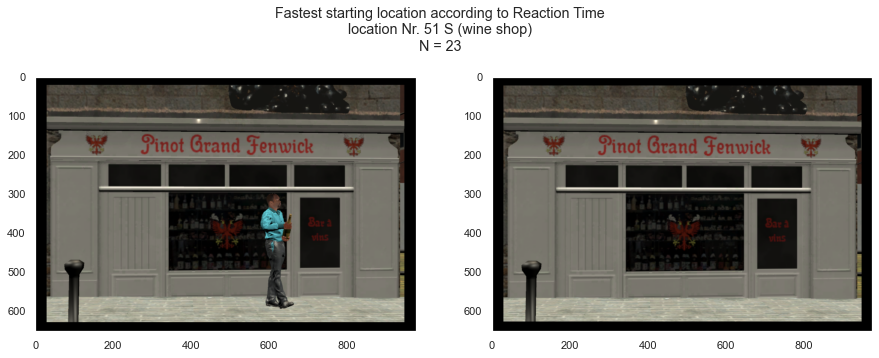

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

img_51_A = mpimg.imread(f'{IMG_PATH}/starting_locations/51_S(wine shop)_A.PNG')
img_51_noA = mpimg.imread(f'{IMG_PATH}/starting_locations/51_S(wine shop)_noA.PNG')

axes[0].imshow(img_51_A)
axes[1].imshow(img_51_noA)

[ax.grid(None) for ax in axes]

plt.suptitle(f'Fastest starting location according to Reaction Time\nlocation Nr. 51 S (wine shop)\nN = {N}', y=1.05)

fig.savefig(f'{PLOT_PATH}/fastest_loc_RT_{N}.png', bbox_inches='tight', dpi=90)

plt.show()

#### Starting location with the `slowest` RT

In [25]:
l_median = lmm_summary_RT.Median.max()
slowest_df = lmm_summary_RT.query('Median==@l_median')
ID = slowest_df.starting_loc_id.values[0]
sl_name = lmm_df.query('starting_loc_id==@ID').starting_loc_name.unique()[0]

display(
    'Slowest starting location',
    f'name: {sl_name}',
    f'ID: {ID}',
    f'median: {np.round(slowest_df.Median.values[0], 3)}',
    f'difference to overall median: {np.round(np.abs(np.median(lmm_summary_RT.Median) - slowest_df.Median.values[0]), 3)}',
    f'overall median: {np.round(np.median(lmm_summary_RT.Median), 3)}',
    f'summary statistics',
    slowest_df,
)

'Slowest starting location'

'name: R (underwater)'

'ID: 35'

'median: 7.747'

'difference to overall median: 1.737'

'overall median: 6.01'

'summary statistics'

,starting_loc_id,starting_loc_name,N,Mean,SD,SE,95% Conf.,Interval,Median
15,35,S (tool shop),272,9.0814,5.983,0.3628,8.3672,9.7956,7.746539


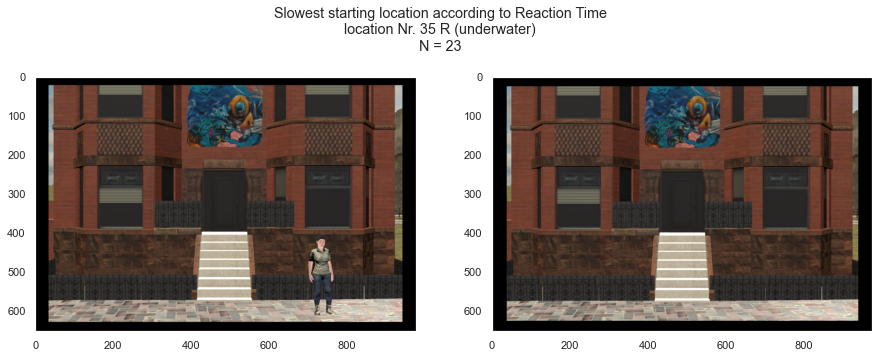

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

img_35_A = mpimg.imread(f'{IMG_PATH}/starting_locations/35_R(underwater)_A.PNG')
img_35_noA = mpimg.imread(f'{IMG_PATH}/starting_locations/35_R(underwater)_noA.PNG')

axes[0].imshow(img_35_A)
axes[1].imshow(img_35_noA)

[ax.grid(None) for ax in axes]

plt.suptitle(f'Slowest starting location according to Reaction Time\nlocation Nr. 35 R (underwater)\nN = {N}', y=1.05)

fig.savefig(f'{PLOT_PATH}/slowest_loc_RT_{N}.png', bbox_inches='tight', dpi=90)

plt.show()

#### Difference between slowest median RT and fastest

In [27]:
np.round((worst_df.Median.values[0] - best_df.Median.values[0]), 3)

33.317

#### Plot

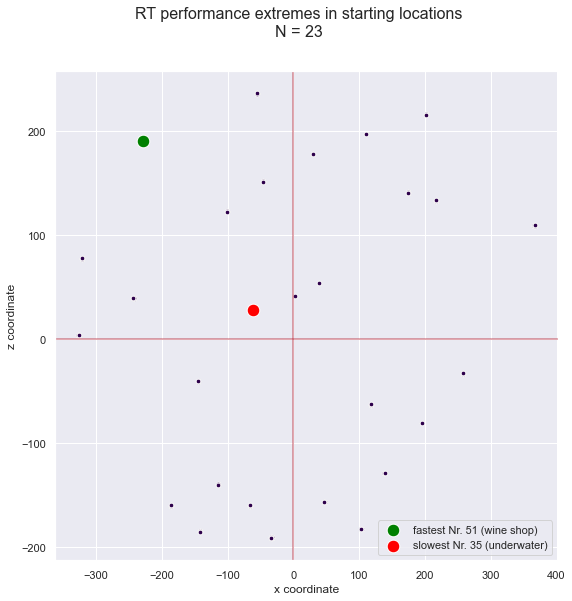

In [28]:
fig, _ = plt.subplots(figsize=(9,9))

fastest_loc_coord = df_cleaned.query('starting_loc_id == 51')[['starting_loc_x', 'starting_loc_z']].drop_duplicates(keep='first')
slowest_loc_coord = df_cleaned.query('starting_loc_id == 35')[['starting_loc_x', 'starting_loc_z']].drop_duplicates(keep='first')

sns.scatterplot(
    data=df_cleaned,
    x='body_pos_x',
    y='body_pos_z',
    s=80,
    marker='.'
).set(xlabel='x coordinate', ylabel='z coordinate')

sns.scatterplot(
    data=fastest_loc_coord,
    x='starting_loc_x',
    y='starting_loc_z',
    s=160,
    c=['green'],
    marker='o',
    label='fastest Nr. 51 (wine shop)',
)

sns.scatterplot(
    data=slowest_loc_coord,
    x='starting_loc_x',
    y='starting_loc_z',
    s=160,
    c=['red'],
    marker='o',
    label='slowest Nr. 35 (underwater)',
)

plt.suptitle(t=f'RT performance extremes in starting locations\nN = {N}', size=16)
plt.axvline(x=0, color=colorblind_palette[2], alpha=.5)
plt.axhline(y=0, color=colorblind_palette[2], alpha=.5)

plt.grid(1)

plt.legend(loc='lower right')

fig.savefig(f'{PLOT_PATH}/fastest_slowest_starting_locations_RT.png', bbox_inches='tight', dpi=90)

plt.show()

#### Results

**Fastest starting location**: Nr. 51 `(S (wine shop))` with the lowest median `4.627` in reaction times.
**Slowest starting location**: Nr. 35 `(R (underwater))` with the highest median `7.747` in reaction times.

**Time difference between reaction times of the best and worst starting location**: `3.119` degree

## Linear Mixed Models

### Angular error

#### Choosing a reference starting location for predicting the `absolute angular error`

In [52]:
overall_median = mean_median_overall.loc['median', ('absolute_180_angles', 'median')]
overall_mean = mean_median_overall.loc['mean', ('absolute_180_angles', 'mean')]

display(
    f'mean: {overall_mean}',
    f'median: {overall_median}'
)

'mean: 48.08740511037776'

'median: 35.21019045157068'

In [53]:
diff_df = (lmm_summary_angle
 .query('Median >= (@overall_median-1) & Median < (@overall_median+1)')
 .assign(
    diff_mean=np.abs(overall_mean - lmm_summary_angle.Mean),
    diff_median=np.abs(overall_median - lmm_summary_angle.Median))
           .sort_values('diff_median', ascending=True)
 )

diff_df

,starting_loc_id,starting_loc_name,N,Mean,SD,SE,95% Conf.,Interval,Median,diff_mean,diff_median
7,18,S (coffee store),274,51.9744,48.8015,2.9482,46.1703,57.7786,35.074110,3.886995,0.136080
14,34,R (daisy),275,47.0189,40.5075,2.4427,42.2100,51.8277,35.346270,1.068505,0.136080
9,20,S (patisserie),276,48.0658,41.1517,2.4770,43.1894,52.9422,35.356497,0.021605,0.146307
0,1,S (tool shop),276,46.7310,41.6004,2.5041,41.8014,51.6605,35.664767,1.356405,0.454577
20,43,S (patisserie),276,51.9477,46.7182,2.8121,46.4117,57.4836,34.293670,3.860295,0.916520


In [54]:
diff_df.diff_median.values[0] == diff_df.diff_median.values[1]

True

Median differences of starting location `18` and `34` from the grand median are identical.

##### Plot mean and median distributions for the angular error

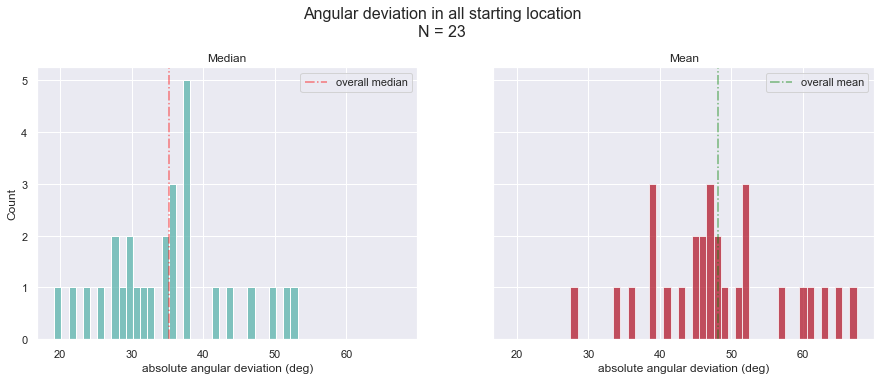

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharex=True, sharey=True)

sns.histplot(
    data=lmm_summary_angle,
    x='Median',
    binwidth=1,
    ax=axes[0],
    color=colorblind_palette[1],
).set(xlabel='absolute angular deviation (deg)', title='Median')

sns.histplot(
    data=lmm_summary_angle,
    x='Mean',
    binwidth=1,
    ax=axes[1],
    color=colorblind_palette[2],
).set(xlabel='absolute angular deviation (deg)', title='Mean')

axes[0].axvline(x=np.median(lmm_summary_angle.Median), alpha=.5, ls='-.', c='r', label='overall median')
axes[1].axvline(x=np.mean(lmm_summary_angle.Mean), alpha=.5, ls='-.', c='g', label='overall mean')

plt.suptitle(f'Angular deviation in all starting location\nN = {N}', size=16, y=1.05)

[ax.legend(loc='upper right') for ax in axes]

plt.show()

fig.savefig(f'{PLOT_PATH}/mean_median_grand_histogram_angle_{N}.png', bbox_inches='tight', dpi=90)

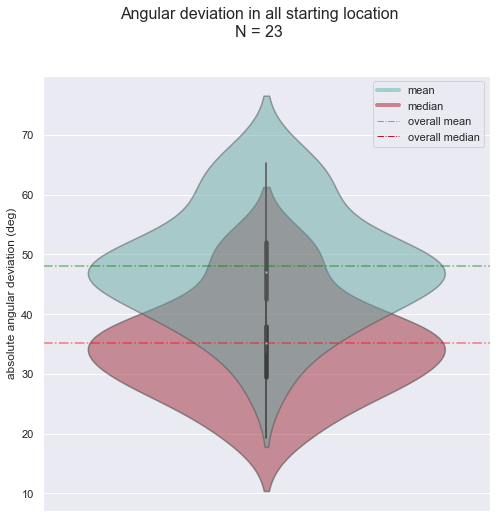

In [56]:
fig, axes = plt.subplots(figsize=(8,8))

sns.violinplot(
    data=lmm_summary_angle,
    y='Median',
    binwidth=1,
    orient='v',
    color=colorblind_palette[2],
)

sns.violinplot(
    data=lmm_summary_angle,
    y='Mean',
    binwidth=1,
    orient='v',
    color=colorblind_palette[1],
)

plt.axhline(y=np.median(lmm_summary_angle.Median), alpha=.5, ls='-.', c='r', label='overall median')
plt.axhline(y=np.mean(lmm_summary_angle.Mean), alpha=.5, ls='-.', c='g', label='overall mean')

plt.suptitle(f'Angular deviation in all starting location\nN = {N}', size=16, y=1)

plt.setp(axes, ylabel='absolute angular deviation (deg)')
plt.setp(axes.collections, alpha=.5)

custom_lines = [Line2D([0], [0], color=colorblind_palette[1], alpha=.5, lw=4),
                Line2D([0], [0], color=colorblind_palette[2], alpha=.5, lw=4),
                Line2D([0], [0], color=colorblind_palette[1], lw=1, ls='-.'),
                Line2D([0], [0], color=colorblind_palette[2], lw=1, ls='-.'),
                ]

plt.legend(handles=custom_lines, labels=['mean', 'median', 'overall mean', 'overall median'])

plt.show()

fig.savefig(f'{PLOT_PATH}/mean_median_grand_violin_angle_{N}.png', bbox_inches='tight', dpi=90)

##### Results

There are starting locations `34 S(fish and chips)` and `18 R(baloons)` with the least difference to the grand median. Since this is the case, the distance of their means from the grand mean of absolute angular error is also secondarily taken into account for choosing one of them as reference for the analysis.
As a result the starting location `34 S(fish and chips)` is taken to be the reference due to its smaller distance from the grand mean.

In [57]:
reference_loc_id_angle = 34

#### Predicting `angular error` based on `starting location`

In [58]:
formula = f'absolute_180_angles ~ C(starting_loc_id, Treatment(reference={reference_loc_id_angle}))'

model_LM_angle_sl = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM_angle_sl.summary())

                             Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           absolute_180_angles
No. Observations:           7708              Method:                       REML               
No. Groups:                 23                Scale:                        1713.9889          
Min. group size:            329               Log-Likelihood:               -39610.1276        
Max. group size:            336               Converged:                    Yes                
Mean group size:            335.1                                                              
-----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------------------------
Intercept                                          46.993    3.720 12

In [59]:
p_values = model_LM_angle_sl.pvalues.reset_index().rename(columns={0 : 'value'})
sig_values = p_values.query('value <= 0.05').sort_values('value')
non_sig_values = p_values.query('value > 0.05').sort_values('value')

display(
    f'significant values:',
    sig_values,

    f'insignificant values:',
    non_sig_values)

'significant values:'

,index,value
0,Intercept,1.376880e-36
27,"C(starting_loc_id, Treatment(reference=34))[T.58]",1.794039e-08
6,"C(starting_loc_id, Treatment(reference=34))[T.9]",3.290941e-08
15,"C(starting_loc_id, Treatment(reference=34))[T.35]",2.006402e-07
4,"C(starting_loc_id, Treatment(reference=34))[T.5]",7.672376e-06
24,"C(starting_loc_id, Treatment(reference=34))[T.52]",7.535029e-05
2,"C(starting_loc_id, Treatment(reference=34))[T.2]",1.346685e-04
14,"C(starting_loc_id, Treatment(reference=34))[T.30]",3.359890e-04
28,subject_id Var,1.278789e-03
25,"C(starting_loc_id, Treatment(reference=34))[T.54]",1.398439e-03


'insignificant values:'

,index,value
7,"C(starting_loc_id, Treatment(reference=34))[T.14]",0.110982
26,"C(starting_loc_id, Treatment(reference=34))[T.55]",0.131396
8,"C(starting_loc_id, Treatment(reference=34))[T.18]",0.156644
20,"C(starting_loc_id, Treatment(reference=34))[T.43]",0.160106
19,"C(starting_loc_id, Treatment(reference=34))[T.40]",0.233877
9,"C(starting_loc_id, Treatment(reference=34))[T.19]",0.260759
16,"C(starting_loc_id, Treatment(reference=34))[T.36]",0.572341
11,"C(starting_loc_id, Treatment(reference=34))[T.21]",0.618760
22,"C(starting_loc_id, Treatment(reference=34))[T.45]",0.633759
23,"C(starting_loc_id, Treatment(reference=34))[T.51]",0.683461


In [60]:
non_sig = [1, 4, 14, 18, 19, 20, 21, 36, 37, 40, 43, 44, 45, 51, 55]
sig = [2, 5, 7, 9, 25, 29, 30, 35, 38, 52, 54, 58]

##### Plots

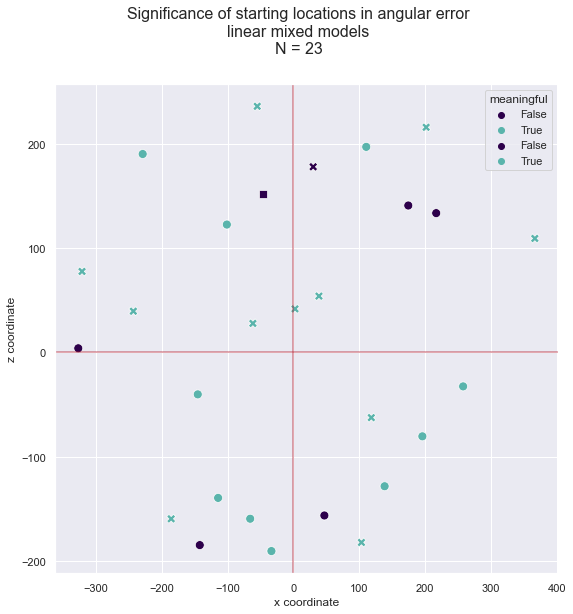

In [207]:
fig, _ = plt.subplots(figsize=(9,9))

ref_df = df_cleaned.query('starting_loc_id == @reference_loc_id_angle')[['starting_loc_x', 'starting_loc_z', 'meaningful']].drop_duplicates(keep='first')
non_sig_coord = df_cleaned.query('starting_loc_id in @non_sig')[['starting_loc_x', 'starting_loc_z', 'meaningful']].drop_duplicates(keep='first')
sig_coord = df_cleaned.query('starting_loc_id in @sig')[['starting_loc_x', 'starting_loc_z', 'meaningful']].drop_duplicates(keep='first')

sns.scatterplot(
    data=ref_df,
    x='starting_loc_x',
    y='starting_loc_z',
    s=80,
    marker='s',
    # label='reference',
).set(xlabel='x coordinate', ylabel='z coordinate')

sns.scatterplot(
    data=non_sig_coord,
    x='starting_loc_x',
    y='starting_loc_z',
    hue='meaningful',
    s=80,
    # c=['green'],
    marker='o',
    # label='non significant',
)

sns.scatterplot(
    data=sig_coord,
    x='starting_loc_x',
    y='starting_loc_z',
    hue='meaningful',
    s=80,
    # c=['red'],
    marker='X',
    # label='significant',
)


plt.suptitle(t=f"Significance of starting locations in angular error\nlinear mixed models\nN = {N}", size=16, y=1)
plt.axvline(x=0, color=colorblind_palette[2], alpha=.5)
plt.axhline(y=0, color=colorblind_palette[2], alpha=.5)

# plt.legend(loc='lower right')

fig.savefig(f'{PLOT_PATH}/significance_starting_locations_angular_error_{N}.png', bbox_inches='tight', dpi=90)

plt.show()

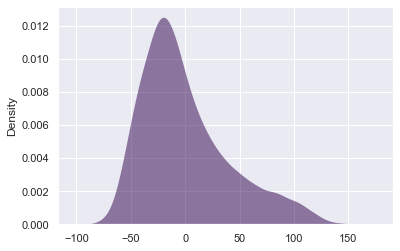

In [62]:
sns.kdeplot(model_LM_angle_sl.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

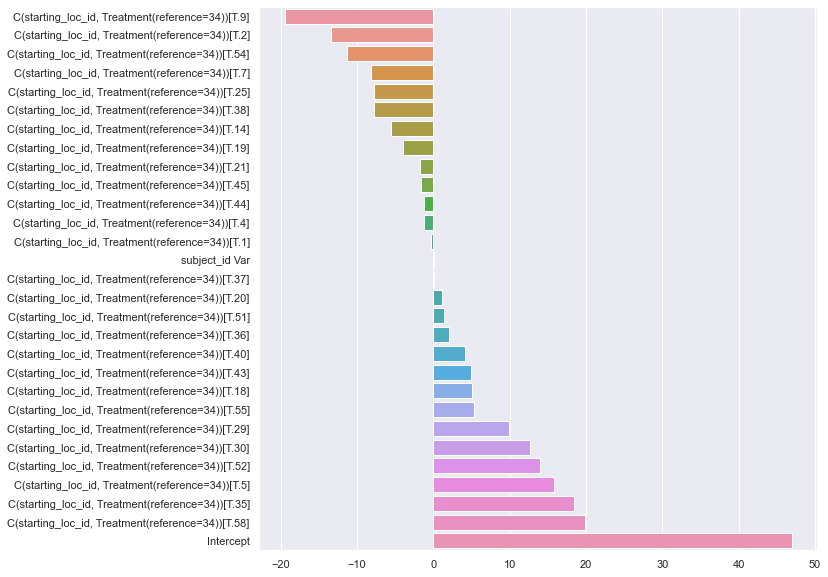

In [64]:
_, _ = plt.subplots(figsize=(10,10))

data = model_LM_angle_sl.params.sort_values()
sns.barplot(
    x=data,
    y=data.index,
)

plt.show()

##### Results

In comparison to starting location 34 (the reference point), starting location `37` has the least difference in angular error degree to the reference and the starting location `58` the most.

The starting locations `1, 4, 14, 18, 19, 20, 21, 36, 37, 40, 43, 44, 45, 51, 55` do not differ significantly from the reference starting location.
The starting locations `2, 5, 7, 9, 25, 29, 30, 35, 38, 52, 54, 58` affect the angular error significantly.


#### Predicting `angular error` based on `starting location` and `distance to target` and their interaction

In [80]:
formula = f'absolute_180_angles ~ C(starting_loc_id, Treatment(reference={reference_loc_id_angle})) + distance_to_target + C(starting_loc_id, Treatment(reference={reference_loc_id_angle})):distance_to_target'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                                      Mixed Linear Model Regression Results
Model:                            MixedLM                 Dependent Variable:                 absolute_180_angles
No. Observations:                 7708                    Method:                             REML               
No. Groups:                       23                      Scale:                              1705.2625          
Min. group size:                  329                     Log-Likelihood:                     -39660.7698        
Max. group size:                  336                     Converged:                          Yes                
Mean group size:                  335.1                                                                          
-----------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------

In [47]:
p_values = model_LM.pvalues.reset_index().rename(columns={0 : 'value'})
sig_values = p_values.query('value <= 0.05').sort_values('value')
non_sig_values = p_values.query('value > 0.05').sort_values('value')

display(
    f'significant values:',
    sig_values,

    f'insignificant values:',
    non_sig_values)

'significant values:'

,index,value
0,Intercept,2.931543e-40
27,"C(starting_loc_id, Treatment(reference=34))[T.58]",3.091401e-08
15,"C(starting_loc_id, Treatment(reference=34))[T.35]",4.377598e-07
6,"C(starting_loc_id, Treatment(reference=34))[T.9]",1.378170e-06
4,"C(starting_loc_id, Treatment(reference=34))[T.5]",1.847498e-05
24,"C(starting_loc_id, Treatment(reference=34))[T.52]",2.943470e-05
28,distance_to_target,3.329336e-05
2,"C(starting_loc_id, Treatment(reference=34))[T.2]",5.002579e-04
14,"C(starting_loc_id, Treatment(reference=34))[T.30]",5.704576e-04
29,subject_id Var,1.280366e-03


'insignificant values:'

,index,value
26,"C(starting_loc_id, Treatment(reference=34))[T.55]",0.050411
8,"C(starting_loc_id, Treatment(reference=34))[T.18]",0.122699
7,"C(starting_loc_id, Treatment(reference=34))[T.14]",0.164005
20,"C(starting_loc_id, Treatment(reference=34))[T.43]",0.172460
19,"C(starting_loc_id, Treatment(reference=34))[T.40]",0.230123
9,"C(starting_loc_id, Treatment(reference=34))[T.19]",0.324129
23,"C(starting_loc_id, Treatment(reference=34))[T.51]",0.377624
16,"C(starting_loc_id, Treatment(reference=34))[T.36]",0.533363
10,"C(starting_loc_id, Treatment(reference=34))[T.20]",0.648809
11,"C(starting_loc_id, Treatment(reference=34))[T.21]",0.677729


##### Plot

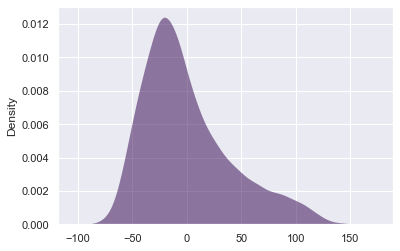

In [48]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

##### Result

In addition to the above reported results, `distance to target` also has a significant effect on the angular error. The interaction of starting location and distance to target is only significant at starting location `58`.

### Reaction Times (RT)

#### Choosing a reference starting location for predicting `RT`

In [49]:
overall_median = mean_median_overall.loc['median', ('RT', 'median')]
overall_mean = mean_median_overall.loc['mean', ('RT', 'mean')]

display(
    f'mean: {overall_mean}',
    f'median: {overall_median}'
)

'mean: 7.76791220145981'

'median: 6.009801149368286'

In [50]:
diff_df = (lmm_summary_RT
           .query('Median >= (@overall_median-0.2) & Median < (@overall_median+0.2)')
           .assign(
    diff_mean=np.abs(overall_mean - lmm_summary_RT.Mean),
    diff_median=np.abs(overall_median - lmm_summary_RT.Median))
           .sort_values('diff_median', ascending=True)
           )

diff_df

,starting_loc_id,starting_loc_name,N,Mean,SD,SE,95% Conf.,Interval,Median,diff_mean,diff_median
12,29,R (foxes),276,7.2204,4.8334,0.2909,6.6476,7.7931,6.004342,0.547512,0.005459
4,7,R (bottle spray),274,7.7374,5.5994,0.3383,7.0715,8.4034,6.015261,0.030512,0.005459
10,21,S (tool shop),274,7.4214,4.9343,0.2981,6.8346,8.0083,5.893713,0.346512,0.116088
27,58,S (tool shop),275,7.4454,5.0049,0.3018,6.8512,8.0395,5.829484,0.322512,0.180317
14,34,R (daisy),275,8.1813,6.0011,0.3619,7.4689,8.8938,6.204588,0.413388,0.194787


In [51]:
diff_df.diff_median.values[0] == diff_df.diff_median.values[1]

True

Median differences of starting location `29` and `7` from the grand median are identical.

##### Plot mean and median distributions for RT

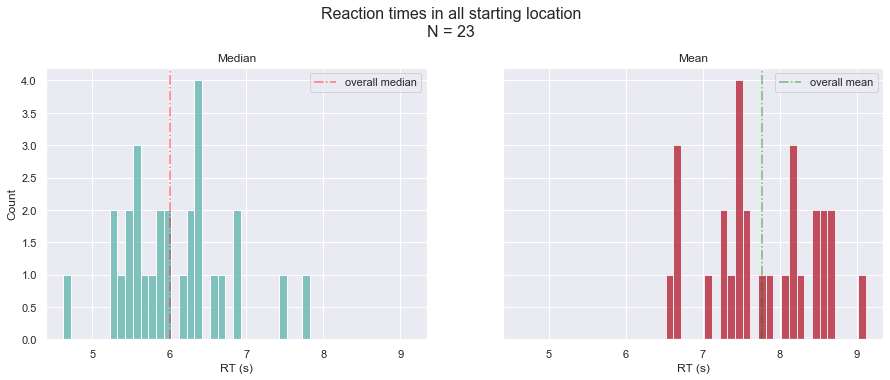

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharex=True, sharey=True)

sns.histplot(
    data=lmm_summary_RT,
    x='Median',
    binwidth=.1,
    ax=axes[0],
    color=colorblind_palette[1],
).set(xlabel='RT (s)', title='Median')

sns.histplot(
    data=lmm_summary_RT,
    x='Mean',
    binwidth=.1,
    ax=axes[1],
    color=colorblind_palette[2],
).set(xlabel='RT (s)', title='Mean')

axes[0].axvline(x=np.median(lmm_summary_RT.Median), alpha=.5, ls='-.', c='r', label='overall median')
axes[1].axvline(x=np.mean(lmm_summary_RT.Mean), alpha=.5, ls='-.', c='g', label='overall mean')

plt.suptitle(f'Reaction times in all starting location\nN = {N}', size=16, y=1.05)

[ax.legend(loc='upper right') for ax in axes]

fig.savefig(f'{PLOT_PATH}/mean_median_grand_histogram_RT_{N}.png', bbox_inches='tight', dpi=90)

plt.show()

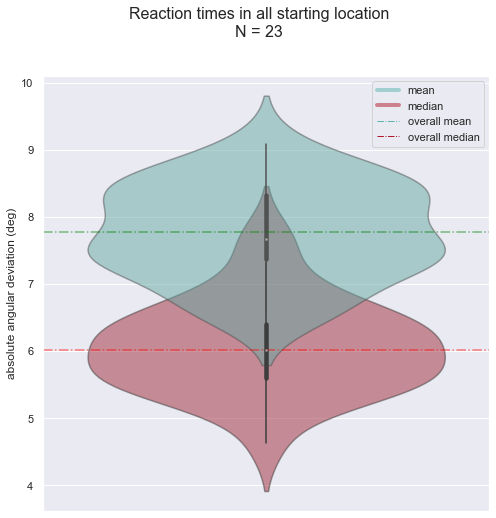

In [51]:
fig, axes = plt.subplots(figsize=(8,8))

sns.violinplot(
    data=lmm_summary_RT,
    y='Median',
    binwidth=1,
    orient='v',
    color=colorblind_palette[2],
)

sns.violinplot(
    data=lmm_summary_RT,
    y='Mean',
    binwidth=1,
    orient='v',
    color=colorblind_palette[1],
)

plt.axhline(y=np.median(lmm_summary_RT.Median), alpha=.5, ls='-.', c='r', label='overall median')
plt.axhline(y=np.mean(lmm_summary_RT.Mean), alpha=.5, ls='-.', c='g', label='overall mean')

plt.suptitle(f'Reaction times in all starting location\nN = {N}', size=16, y=1)

plt.setp(axes, ylabel='absolute angular deviation (deg)')
plt.setp(axes.collections, alpha=.5)

custom_lines = [Line2D([0], [0], color=colorblind_palette[1], alpha=.5, lw=4),
                Line2D([0], [0], color=colorblind_palette[2], alpha=.5, lw=4),
                Line2D([0], [0], color=colorblind_palette[1], lw=1, ls='-.'),
                Line2D([0], [0], color=colorblind_palette[2], lw=1, ls='-.'),
                ]

plt.legend(handles=custom_lines, labels=['mean', 'median', 'overall mean', 'overall median'])

plt.show()

fig.savefig(f'{PLOT_PATH}/mean_median_grand_violin_RT_{N}.png', bbox_inches='tight', dpi=90)

##### Results

There are starting locations `29 R(foxes)` and `7 R(bottle spray)` with the least difference to the grand median. Since this is the case, the distance of their means from the grand mean of RT is also secondarily taken into account for choosing one of them as reference for the analysis.
As a result the starting location `7 R(bottle spray)` is taken to be the reference due to its smaller distance from the grand mean.

In [53]:
reference_loc_id_RT = 7

#### Predicting `RT` based on `starting location`

In [54]:
formula = f'RT ~ C(starting_loc_id, Treatment(reference={reference_loc_id_RT}))'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                           Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            RT         
No. Observations:             7708               Method:                        REML       
No. Groups:                   23                 Scale:                         26.9503    
Min. group size:              329                Log-Likelihood:                -23667.5718
Max. group size:              336                Converged:                     Yes        
Mean group size:              335.1                                                        
-------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                         7.736    0.512 15.116 0.000  6.733  8.739
C(starting_loc_

In [55]:
p_values = model_LM.pvalues.reset_index().rename(columns={0 : 'value'})
sig_values = p_values.query('value <= 0.05').sort_values('value')
non_sig_values = p_values.query('value > 0.05').sort_values('value')

display(
    f'significant values:',
    sig_values,

    f'insignificant values:',
    non_sig_values)

'significant values:'

,index,value
0,Intercept,1.271941e-51
28,subject_id Var,1.185895e-03
15,"C(starting_loc_id, Treatment(reference=7))[T.35]",2.904587e-03
8,"C(starting_loc_id, Treatment(reference=7))[T.19]",5.863308e-03
9,"C(starting_loc_id, Treatment(reference=7))[T.20]",1.491184e-02
3,"C(starting_loc_id, Treatment(reference=7))[T.4]",1.802955e-02
23,"C(starting_loc_id, Treatment(reference=7))[T.51]",1.863588e-02
17,"C(starting_loc_id, Treatment(reference=7))[T.37]",3.287137e-02
20,"C(starting_loc_id, Treatment(reference=7))[T.43]",3.592705e-02


'insignificant values:'

,index,value
7,"C(starting_loc_id, Treatment(reference=7))[T.18]",0.051657
4,"C(starting_loc_id, Treatment(reference=7))[T.5]",0.063697
19,"C(starting_loc_id, Treatment(reference=7))[T.40]",0.078145
13,"C(starting_loc_id, Treatment(reference=7))[T.30]",0.098178
2,"C(starting_loc_id, Treatment(reference=7))[T.2]",0.127066
6,"C(starting_loc_id, Treatment(reference=7))[T.14]",0.221112
12,"C(starting_loc_id, Treatment(reference=7))[T.29]",0.244220
22,"C(starting_loc_id, Treatment(reference=7))[T.45]",0.289021
14,"C(starting_loc_id, Treatment(reference=7))[T.34]",0.314648
25,"C(starting_loc_id, Treatment(reference=7))[T.54]",0.323468


In [64]:
non_sig = [1, 2, 5, 9, 14, 18, 21, 25, 29, 30, 34, 36, 38, 40, 44, 45, 52, 54, 55, 58]
sig = [4, 19, 20, 35, 37, 43, 51]

##### Plots

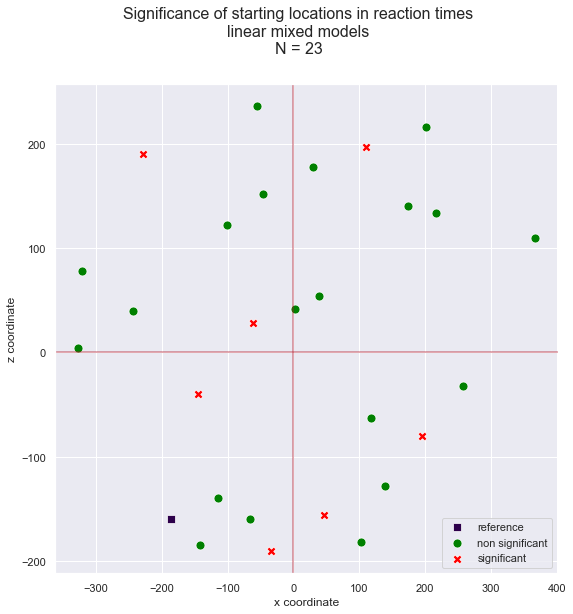

In [65]:
fig, _ = plt.subplots(figsize=(9,9))

ref_df = df_cleaned.query('starting_loc_id == @reference_loc_id_RT')[['starting_loc_x', 'starting_loc_z']].drop_duplicates(keep='first')
non_sig_coord = df_cleaned.query('starting_loc_id in @non_sig')[['starting_loc_x', 'starting_loc_z']].drop_duplicates(keep='first')
sig_coord = df_cleaned.query('starting_loc_id in @sig')[['starting_loc_x', 'starting_loc_z']].drop_duplicates(keep='first')

sns.scatterplot(
    data=ref_df,
    x='starting_loc_x',
    y='starting_loc_z',
    s=80,
    marker='s',
    label='reference',
).set(xlabel='x coordinate', ylabel='z coordinate')

sns.scatterplot(
    data=non_sig_coord,
    x='starting_loc_x',
    y='starting_loc_z',
    s=80,
    c=['green'],
    marker='o',
    label='non significant',
)

sns.scatterplot(
    data=sig_coord,
    x='starting_loc_x',
    y='starting_loc_z',
    s=80,
    c=['red'],
    marker='X',
    label='significant',
)


plt.suptitle(t=f'Significance of starting locations in reaction times\nlinear mixed models\nN = {N}', size=16, y=1)
plt.axvline(x=0, color=colorblind_palette[2], alpha=.5)
plt.axhline(y=0, color=colorblind_palette[2], alpha=.5)

plt.legend(loc='lower right')

fig.savefig(f'{PLOT_PATH}/significance_starting_locations_RT_{N}.png', bbox_inches='tight', dpi=90)

plt.show()

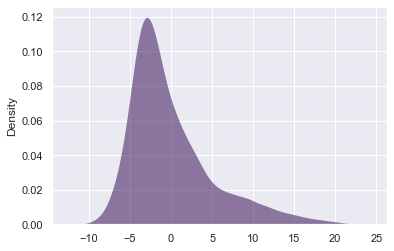

In [66]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

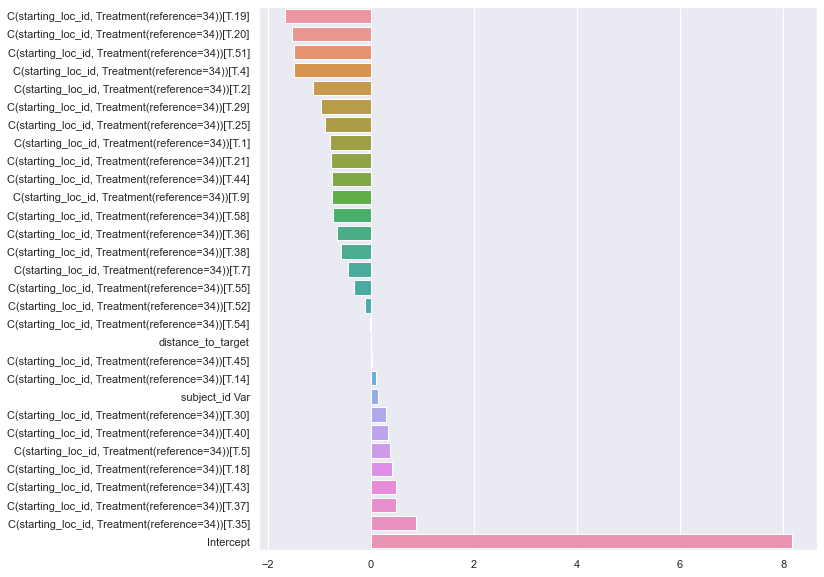

In [67]:
_, _ = plt.subplots(figsize=(10,10))

data = model_LM.params.sort_values()
sns.barplot(
    x=data,
    y=data.index,
)

plt.show()

##### Results

In comparison to starting location 7 (the reference point), starting location `35` has the least difference in reaction time to the reference and the starting location `19` the most.

The starting locations `1, 2, 5, 9, 14, 18, 21, 25, 29, 30, 34, 36, 38, 40, 44, 45, 52, 54, 55, 58` do not differ significantly from the reference starting location.
The starting locations `4, 19, 20, 35, 37, 43, 51` affect the reaction times significantly.

#### Predicting `RT` based on `starting location` and `distance to target` and their interaction

In [81]:
formula = f'RT ~ C(starting_loc_id, Treatment(reference={reference_loc_id_angle})) + distance_to_target + C(starting_loc_id, Treatment(reference={reference_loc_id_angle})):distance_to_target'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                                     Mixed Linear Model Regression Results
Model:                              MixedLM                   Dependent Variable:                   RT         
No. Observations:                   7708                      Method:                               REML       
No. Groups:                         23                        Scale:                                26.9754    
Min. group size:                    329                       Log-Likelihood:                       -23799.5171
Max. group size:                    336                       Converged:                            Yes        
Mean group size:                    335.1                                                                      
---------------------------------------------------------------------------------------------------------------
                                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------

In [69]:
p_values = model_LM.pvalues.reset_index().rename(columns={0 : 'value'})
sig_values = p_values.query('value <= 0.05').sort_values('value')
non_sig_values = p_values.query('value > 0.05').sort_values('value')

display(
    f'significant values:',
    sig_values,

    f'insignificant values:',
    non_sig_values)

'significant values:'

,index,value
0,Intercept,9.176391e-55
9,"C(starting_loc_id, Treatment(reference=34))[T.19]",1.652974e-04
10,"C(starting_loc_id, Treatment(reference=34))[T.20]",5.690017e-04
3,"C(starting_loc_id, Treatment(reference=34))[T.4]",7.378006e-04
23,"C(starting_loc_id, Treatment(reference=34))[T.51]",7.976776e-04
29,subject_id Var,1.185962e-03
2,"C(starting_loc_id, Treatment(reference=34))[T.2]",1.121481e-02
13,"C(starting_loc_id, Treatment(reference=34))[T.29]",2.974348e-02
12,"C(starting_loc_id, Treatment(reference=34))[T.25]",4.650018e-02
15,"C(starting_loc_id, Treatment(reference=34))[T.35]",4.774641e-02


'insignificant values:'

,index,value
1,"C(starting_loc_id, Treatment(reference=34))[T.1]",0.076928
11,"C(starting_loc_id, Treatment(reference=34))[T.21]",0.086103
21,"C(starting_loc_id, Treatment(reference=34))[T.44]",0.086592
27,"C(starting_loc_id, Treatment(reference=34))[T.58]",0.097153
6,"C(starting_loc_id, Treatment(reference=34))[T.9]",0.097710
16,"C(starting_loc_id, Treatment(reference=34))[T.36]",0.139566
18,"C(starting_loc_id, Treatment(reference=34))[T.38]",0.192898
17,"C(starting_loc_id, Treatment(reference=34))[T.37]",0.261375
20,"C(starting_loc_id, Treatment(reference=34))[T.43]",0.274214
5,"C(starting_loc_id, Treatment(reference=34))[T.7]",0.312143


##### Plot

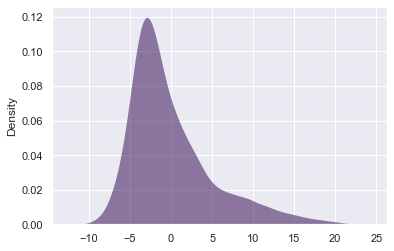

In [70]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

##### Result

`Distance to target` does not have a significant effect on the reaction times. There is also no interaction between the target distance and the reaction times.